In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 12345
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
df = pd.read_csv("../data/data.mood.csv")

In [3]:
df.shape

(1188, 44)

In [4]:
df.columns

Index(['Unnamed: 0', 'vpn_nr', 'esm_id', 'group', 'bildung', 'bdi',
       'nr_of_episodes', 'nobs_mood', 'trigger_counter', 'form', 'traurig_re',
       'niedergeschlagen_re', 'unsicher_re', 'nervos_re', 'glucklich_re',
       'frohlich_re', 'mood_sad.5', 'mood_fearful.5', 'mood_neg.5',
       'mood_happy.5', 'cesd_sum', 'rrs_sum', 'rrs_brood', 'rrs_reflect',
       'forecast_sad', 'forecast_fear', 'forecast_neg', 'forecast_happy',
       'recall_sad', 'recall_fear', 'recall_neg', 'recall_happy',
       'diff_neg.fore.5', 'diff_sad.fore.5', 'diff_fear.fore.5',
       'diff_happy.fore.5', 'diff_neg.retro.5', 'diff_sad.retro.5',
       'diff_fear.retro.5', 'diff_happy.retro.5', 'mood_sad5_tm1',
       'mood_neg5_tm1', 'mood_fearful5_tm1', 'mood_happy5_tm1'],
      dtype='object')

In [5]:
df = df[["esm_id", "group", "bdi"]]
df.head()

,esm_id,group,bdi
0,10,mdd,25.0
1,10,mdd,25.0
2,10,mdd,25.0
3,10,mdd,25.0
4,10,mdd,25.0


In [6]:
df = df.drop_duplicates(keep="first")

In [7]:
df.shape

(67, 3)

In [8]:
df.head()

,esm_id,group,bdi
0,10,mdd,25.0
14,9,mdd,30.0
29,6,mdd,26.0
45,7,mdd,35.0
64,12,mdd,44.0


In [9]:
print(*df["bdi"])

25.0 30.0 26.0 35.0 44.0 30.0 22.0 33.0 43.0 43.0 24.0 39.0 19.0 3.0 nan 0.0 25.0 0.0 1.0 31.0 28.0 2.0 0.0 0.0 2.0 0.0 0.0 0.0 7.0 30.0 0.0 35.0 0.0 1.0 0.0 2.0 31.0 26.0 0.0 1.0 0.0 0.0 0.0 1.0 36.0 41.0 26.0 35.0 33.0 12.0 28.0 1.0 27.0 34.0 22.0 27.0 1.0 3.0 1.0 5.0 3.0 9.0 0.0 2.0 0.0 0.0 1.0


In [10]:
df = df[pd.notnull(df["bdi"])]

In [11]:
df.shape

(66, 3)

In [12]:
print(*df["bdi"].sort_values())

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 2.0 2.0 3.0 3.0 3.0 5.0 7.0 9.0 12.0 19.0 22.0 22.0 24.0 25.0 25.0 26.0 26.0 26.0 27.0 27.0 28.0 28.0 30.0 30.0 30.0 31.0 31.0 33.0 33.0 34.0 35.0 35.0 35.0 36.0 39.0 41.0 43.0 43.0 44.0


In [13]:
df = df.copy()
df["bdi_class"] = pd.cut(df["bdi"], bins=[0, 13.5, 19.5, 28.5, 63], include_lowest=True)

In [14]:
print(df)

      esm_id group   bdi       bdi_class
0         10   mdd  25.0    (19.5, 28.5]
14         9   mdd  30.0    (28.5, 63.0]
29         6   mdd  26.0    (19.5, 28.5]
45         7   mdd  35.0    (28.5, 63.0]
64        12   mdd  44.0    (28.5, 63.0]
...      ...   ...   ...             ...
1104      99   ctl   0.0  (-0.001, 13.5]
1120     100   ctl   2.0  (-0.001, 13.5]
1132     104   ctl   0.0  (-0.001, 13.5]
1151     103   ctl   0.0  (-0.001, 13.5]
1170     102   ctl   1.0  (-0.001, 13.5]

[66 rows x 4 columns]


In [15]:
df["bdi_class"].value_counts()

bdi_class
(-0.001, 13.5]    36
(28.5, 63.0]      17
(19.5, 28.5]      12
(13.5, 19.5]       1
Name: count, dtype: int64

In [16]:
abs_freq = pd.crosstab(index=df["bdi_class"], columns=["Abs. freq."], colnames=[""])
abs_freq

,Abs. freq.
bdi_class,
"(-0.001, 13.5]",36
"(13.5, 19.5]",1
"(19.5, 28.5]",12
"(28.5, 63.0]",17


In [17]:
rel_freq = abs_freq / abs_freq.sum()
rel_freq

,Abs. freq.
bdi_class,
"(-0.001, 13.5]",0.545455
"(13.5, 19.5]",0.015152
"(19.5, 28.5]",0.181818
"(28.5, 63.0]",0.257576


In [18]:
rel_freq.sum()


Abs. freq.    1.0
dtype: float64

In [19]:
rel_freq = pd.crosstab(
    index=df["bdi_class"], columns=["Rel. freq."], colnames=[""], normalize=True
)
rel_freq

,Rel. freq.
bdi_class,
"(-0.001, 13.5]",0.545455
"(13.5, 19.5]",0.015152
"(19.5, 28.5]",0.181818
"(28.5, 63.0]",0.257576


In [20]:
rel_freq.round(2)

,Rel. freq.
bdi_class,
"(-0.001, 13.5]",0.55
"(13.5, 19.5]",0.02
"(19.5, 28.5]",0.18
"(28.5, 63.0]",0.26


In [21]:
grp_freq = pd.crosstab(index=df["group"], columns=["Abs. freq."], colnames=[""])
grp_freq

,Abs. freq.
group,
ctl,36
mdd,30


In [22]:
grp_freq.loc[["mdd", "ctl"], :]

,Abs. freq.
group,
mdd,30
ctl,36


In [23]:
bdi_group_abs_freq = pd.crosstab(index=df["bdi_class"], columns=df["group"])
bdi_group_abs_freq

group,ctl,mdd
bdi_class,,
"(-0.001, 13.5]",36,0
"(13.5, 19.5]",0,1
"(19.5, 28.5]",0,12
"(28.5, 63.0]",0,17


In [24]:
bdi_group_rel_freq = pd.crosstab(
    index=df["bdi_class"], columns=df["group"], normalize=True
)

bdi_group_rel_freq

group,ctl,mdd
bdi_class,,
"(-0.001, 13.5]",0.545455,0.000000
"(13.5, 19.5]",0.000000,0.015152
"(19.5, 28.5]",0.000000,0.181818
"(28.5, 63.0]",0.000000,0.257576


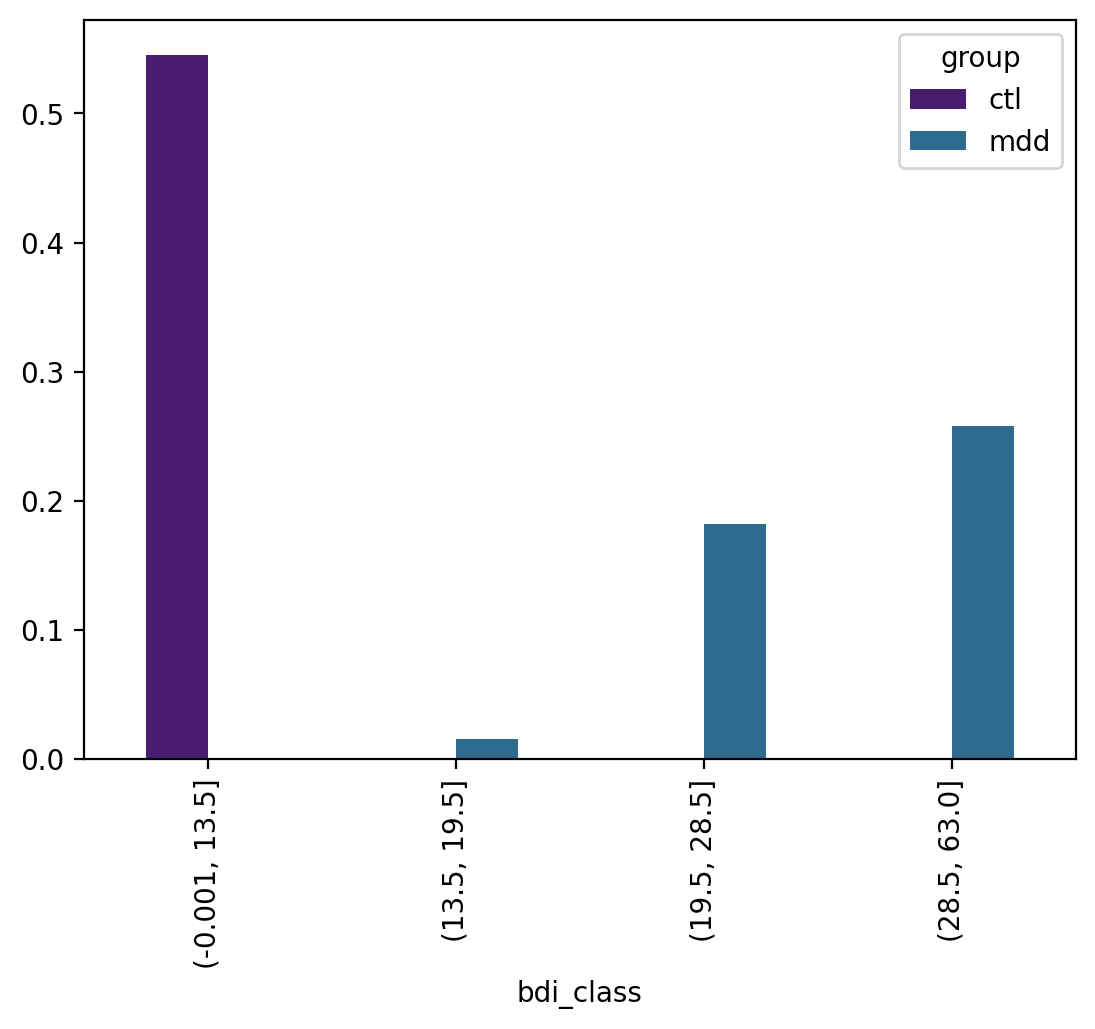

In [25]:
bdi_group_rel_freq.plot.bar();

In [26]:
pd.crosstab(index=df["bdi_class"], columns=df["group"], margins=True)

group,ctl,mdd,All
bdi_class,,,
"(-0.001, 13.5]",36,0,36
"(13.5, 19.5]",0,1,1
"(19.5, 28.5]",0,12,12
"(28.5, 63.0]",0,17,17
All,36,30,66


In [27]:
pd.crosstab(index=df["bdi_class"], columns=df["group"], margins=True, normalize="all")

group,ctl,mdd,All
bdi_class,,,
"(-0.001, 13.5]",0.545455,0.000000,0.545455
"(13.5, 19.5]",0.000000,0.015152,0.015152
"(19.5, 28.5]",0.000000,0.181818,0.181818
"(28.5, 63.0]",0.000000,0.257576,0.257576
All,0.545455,0.454545,1.000000


In [28]:
pd.crosstab(
    index=df["bdi_class"], columns=df["group"], margins=True, normalize="columns"
)

group,ctl,mdd,All
bdi_class,,,
"(-0.001, 13.5]",1.0,0.000000,0.545455
"(13.5, 19.5]",0.0,0.033333,0.015152
"(19.5, 28.5]",0.0,0.400000,0.181818
"(28.5, 63.0]",0.0,0.566667,0.257576


In [29]:
pd.crosstab(index=df["bdi_class"], columns=df["group"], margins=True, normalize="index")

group,ctl,mdd
bdi_class,,
"(-0.001, 13.5]",1.000000,0.000000
"(13.5, 19.5]",0.000000,1.000000
"(19.5, 28.5]",0.000000,1.000000
"(28.5, 63.0]",0.000000,1.000000
All,0.545455,0.454545


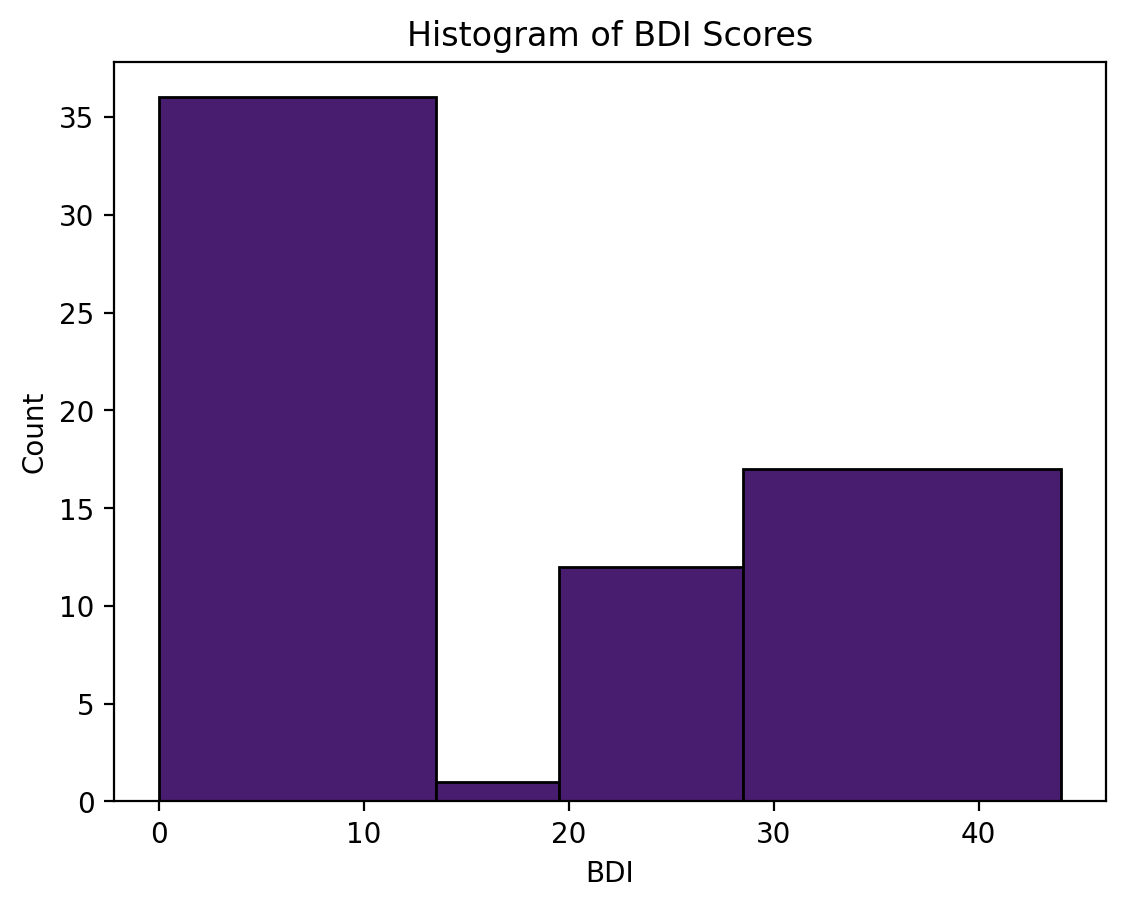

In [30]:
bdi_bins = [0, 13.5, 19.5, 28.5, 44]

plt.hist(df["bdi"], bins=bdi_bins, edgecolor="black")
plt.xlabel("BDI")
plt.ylabel("Count")
plt.title("Histogram of BDI Scores")
plt.show()

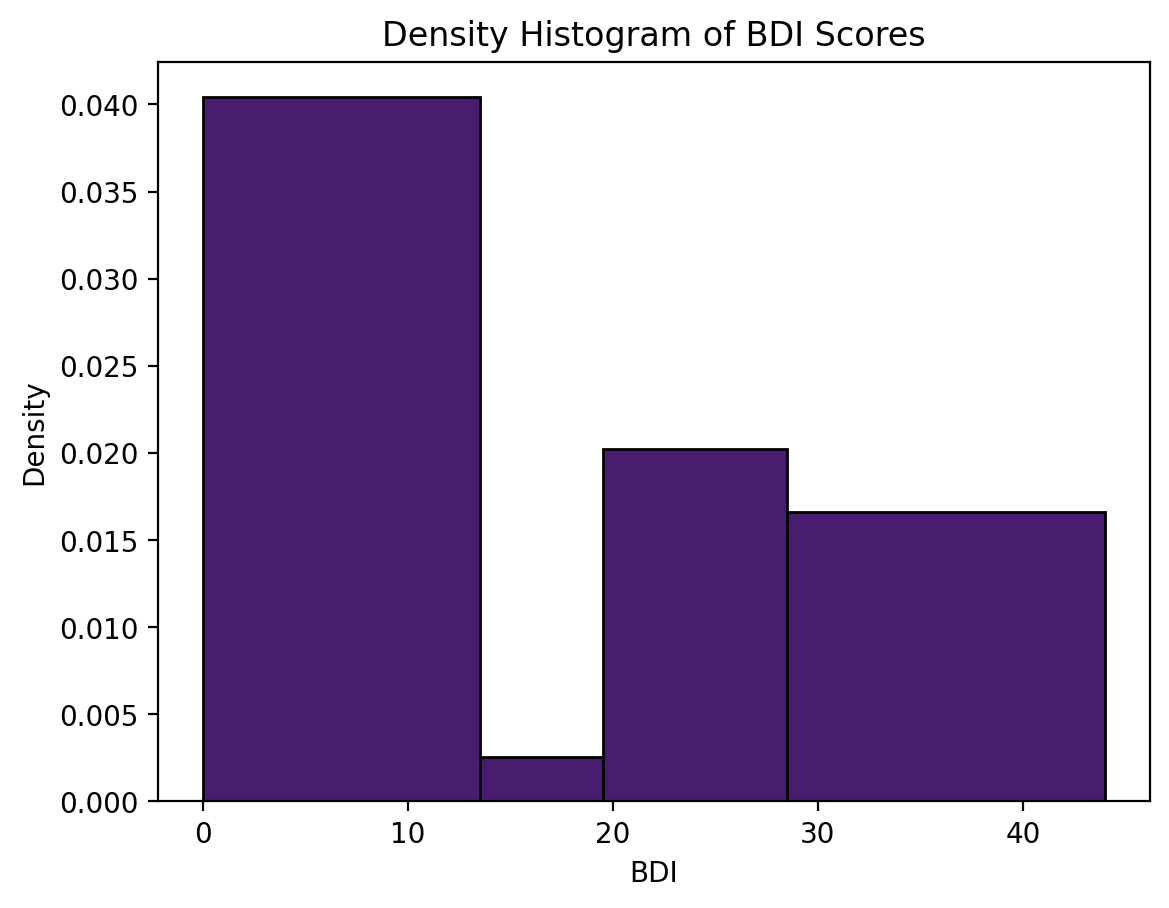

In [31]:
bdi_bins = [0, 13.5, 19.5, 28.5, 44]

plt.hist(df["bdi"], bins=bdi_bins, density=True, edgecolor="black")
plt.xlabel("BDI")
plt.ylabel("Density")
plt.title("Density Histogram of BDI Scores")
plt.show()

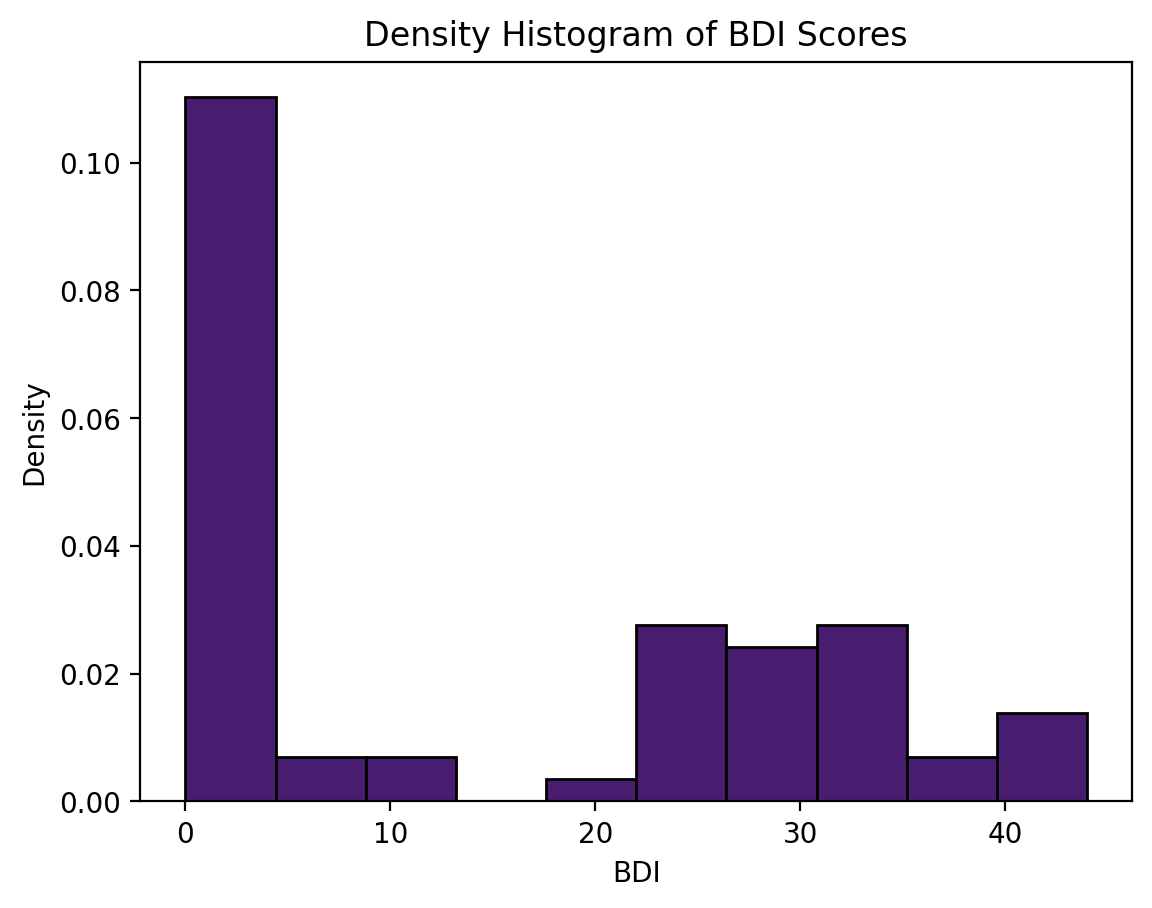

In [32]:
plt.hist(df["bdi"], density=True, edgecolor="black")
plt.xlabel("BDI")
plt.ylabel("Density")
plt.title("Density Histogram of BDI Scores")
plt.show()

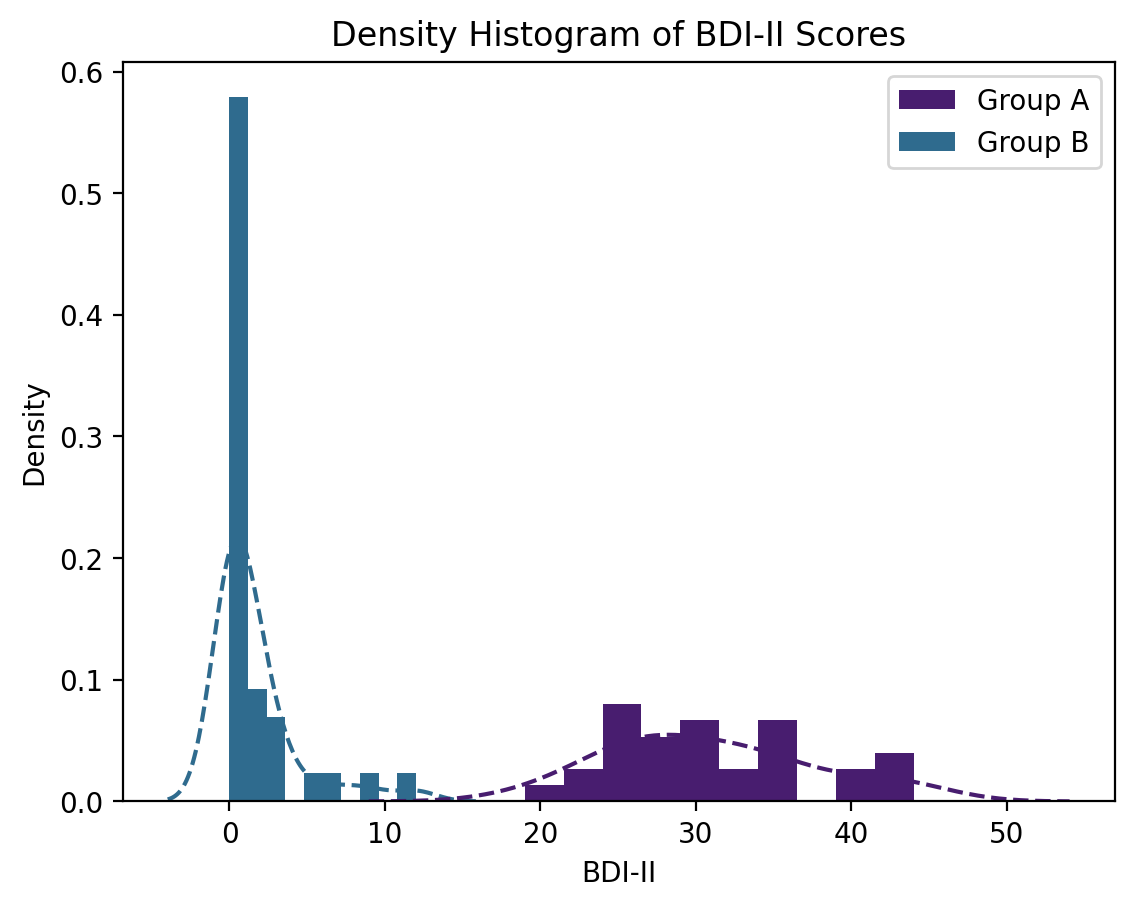

In [33]:
plt.hist(df[df["group"] == "mdd"]["bdi"], density=True, label="Group A")
plt.hist(df[df["group"] == "ctl"]["bdi"], density=True, label="Group B")
sns.kdeplot(data=df, x="bdi", hue="group", common_norm=False, linestyle='dashed')
plt.xlabel("BDI-II")
plt.ylabel("Density")
plt.title("Density Histogram of BDI-II Scores")
plt.legend()
plt.show();

In [34]:
x = [19, 26, 27, 28, 28, 33, 33, 41, 43]
np.quantile(x, 2 / 3)

33.0

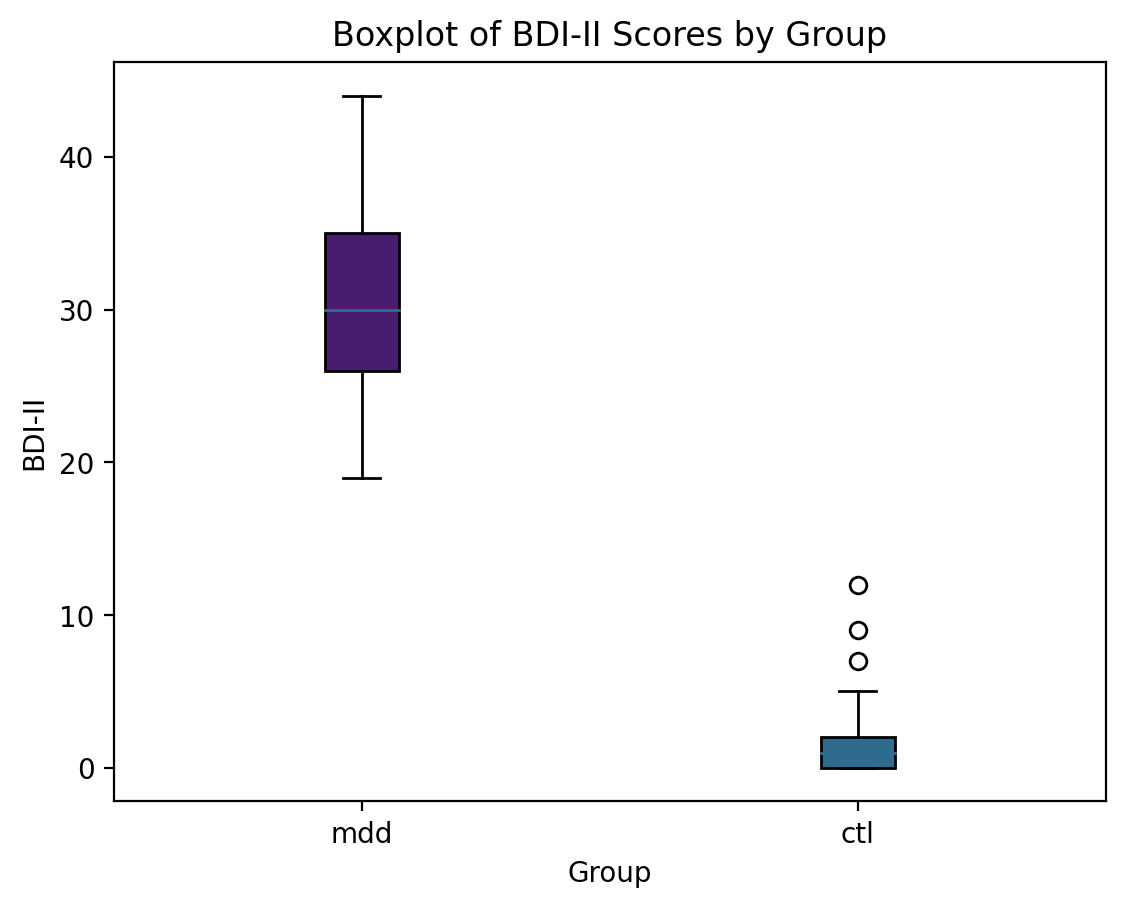

In [35]:
groups = df["group"].unique()
colors = ["C0", "C1"]

for i, group in enumerate(groups):
    subset = df[df["group"] == group]
    plt.boxplot(
        subset["bdi"],
        positions=[i],
        labels=[group],
        patch_artist=True,
        boxprops=dict(facecolor=colors[i]),
    )

plt.xlabel("Group")
plt.ylabel("BDI-II")
plt.title("Boxplot of BDI-II Scores by Group")
plt.show()

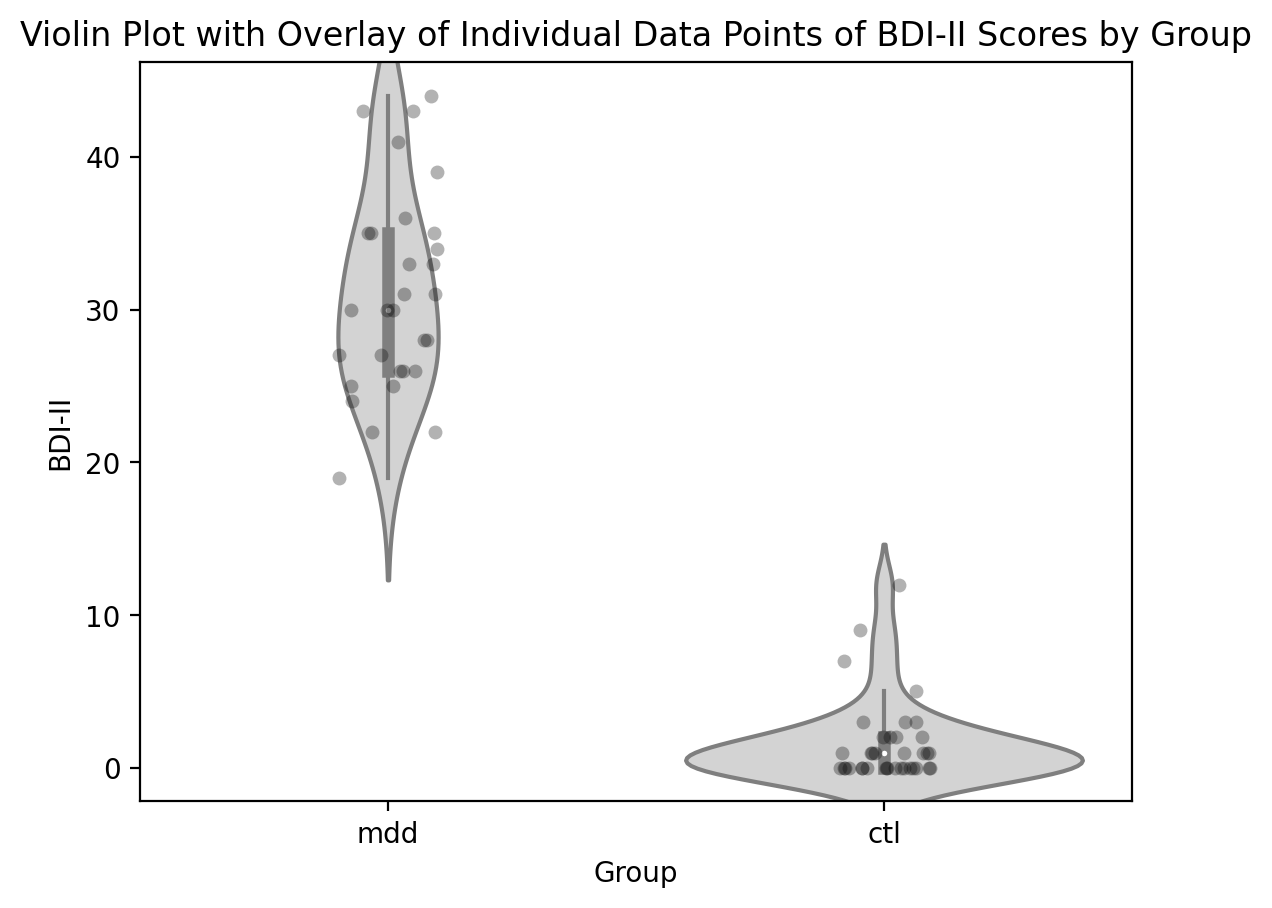

In [36]:
# Create the violin plot
sns.violinplot(x="group", y="bdi", data=df, color="lightgray")

# Overlay the individual data points using stripplot
sns.stripplot(x="group", y="bdi", data=df, color="black", size=5, jitter=True, alpha=0.3)

plt.ylabel("BDI-II")
plt.xlabel("Group")
plt.title("Violin Plot with Overlay of Individual Data Points of BDI-II Scores by Group")
plt.show()

In [37]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Sep 17 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

pandas    : 2.0.3
arviz     : 0.16.0
numpy     : 1.25.2
matplotlib: 3.7.2
seaborn   : 0.12.2

Watermark: 2.4.3

